# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lime.lime_tabular
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from SyntheticDataset import SyntheticDataset
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup

In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"] + "/synth_tests"

In [3]:
config_file = open('visual_config.json')
config_vars = json.load(config_file)
config_file.close()

shap_colors_neg = config_vars["shap_colors"]["negative"]
shap_colors_pos = config_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = config_vars["title_font_size"]
label_size = config_vars["labels_font_size"]

green_color = tuple([x/255 for x in config_vars["green_colors"]["c2"]])

# Get Dataset

In [4]:
perf_analysis = PerformanceAnalysis()

min_val = -100
max_val = 100
num_rows = 1000
num_features = 10
num_classes = 2

features_names = ["Var" + (str(x)) for x in range(num_features)]

std_dev = np.array([1.75 - (0.1 * i) for i in range(num_features)])
class_sep = np.ones(num_features) * 0.65

# rand_coef = [[0.95 - 1 / (num_features * 2) * x, 0.95 - 1 / (num_features * 2) * x] for x in range(num_features)]

# dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, rand_coef, seed=42)
dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, seed=42, norm_dist=True, std_dev_perc=std_dev, class_sep_perc=class_sep)

dataset.generate()
dataset.get_data()

array([[-16.28396084, -17.85402915, -29.23192034, ..., -12.98107225,
        -21.90913518,   0.        ],
       [-55.48923244, -36.8567103 , -35.0283123 , ...,  11.33503427,
        -50.24157009,   0.        ],
       [ -3.28841413, -27.92795015,  -5.22661699, ...,  10.78247723,
        -21.96695473,   0.        ],
       ...,
       [ 10.85230779,  14.74984791,  80.26095417, ...,  -9.82850496,
         30.88748713,   1.        ],
       [ 11.1317982 ,   2.29092448,  39.30443933, ...,  72.03583926,
         54.99980163,   1.        ],
       [ 31.33615292,  80.14396943,   8.04825168, ...,  36.04879293,
         24.66862436,   1.        ]])

In [5]:
#rand_coef

In [6]:
data_analysis = DatasetAnalysis()

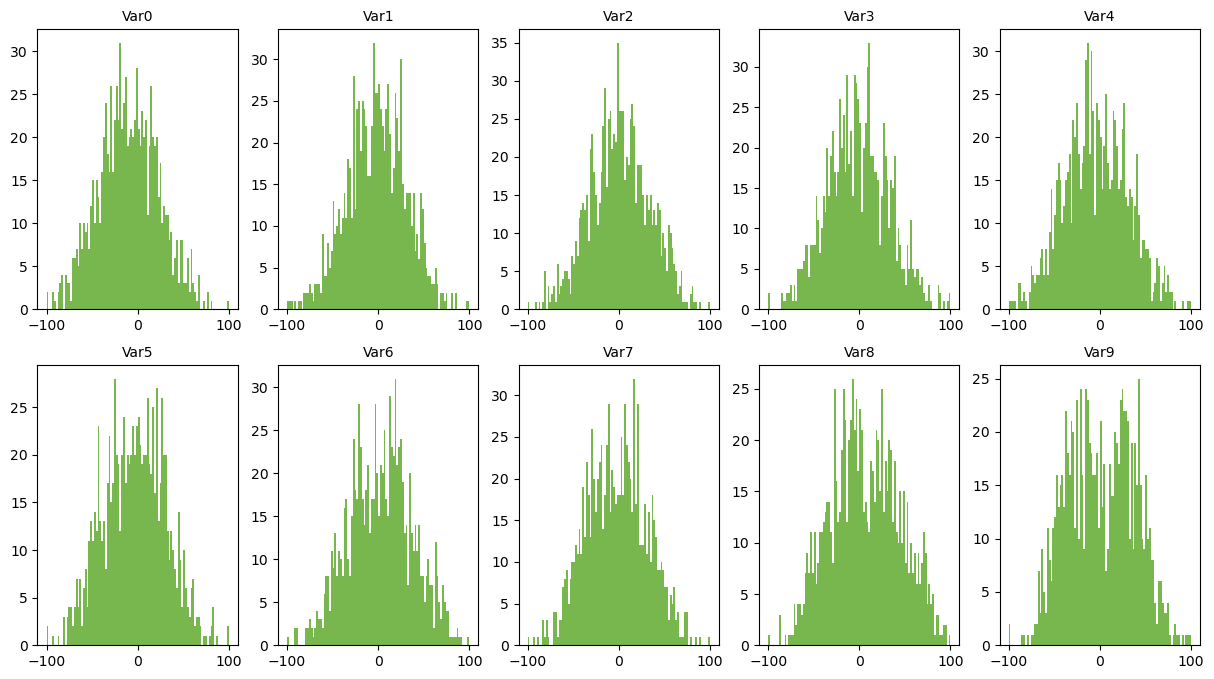

In [10]:
data_analysis.feat_hist(dataset.get_x(), 2, 5, figsize=(15, 8), color=green_color, feat_names=features_names, bins=100)

In [821]:
sss_nsplits = 10
sss = StratifiedShuffleSplit(n_splits=sss_nsplits, test_size=0.2, random_state=42)


lr_clfs = []
lr_limes = []
lr_shaps = []
rf_clfs = []
rf_limes = []
rf_shaps = []
svm_clfs = []
svm_limes = []
svm_shaps = []
ebm_clfs = []

In [822]:
X_trains_pd = []
X_tests_pd = []
Y_trains = []
Y_tests = []

var_test = 9
for i, (train_index, test_index) in enumerate(sss.split(dataset.get_x()[:, var_test], dataset.get_y())):
    X_train_pd = pd.DataFrame(dataset.get_x()[train_index, var_test], columns=[features_names[var_test]])
    X_test_pd = pd.DataFrame(dataset.get_x()[test_index, var_test], columns=[features_names[var_test]])

    X_trains_pd.append(X_train_pd)
    X_tests_pd.append(X_test_pd)
    Y_trains.append(dataset.get_y()[train_index])
    Y_tests.append(dataset.get_y()[test_index])


#### Instance to extract local explanations for all models

In [824]:
Exp_index = 3

# Classification

In [825]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [826]:
for i in range(sss_nsplits):
    lr_clf = LogisticRegression(solver="liblinear", max_iter=100, C=0.1, random_state=42).fit(X_trains_pd[i].to_numpy(), Y_trains[i])
    lr_clfs.append(lr_clf)

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [827]:
for i in range(sss_nsplits):
    lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_trains_pd[i].to_numpy(), feature_names=features_names)
    lr_limes.append(lr_LIME_explainer)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [829]:
shap.initjs()

In [830]:
for i in range(sss_nsplits):
    lr_SHAP_exp = shap.KernelExplainer(lr_clfs[i].predict_proba, shap.sample(X_trains_pd[i], 20))
    lr_shaps.append(lr_SHAP_exp)

## <i>Random Forest</i> (RF)

In [834]:
for i in range(sss_nsplits):
    rf_clf = RandomForestClassifier(n_estimators=1000, bootstrap=False, max_features="sqrt", random_state=42).fit(X_trains_pd[i].to_numpy(), Y_trains[i])
    rf_clfs.append(rf_clf)

### Extract Explanations 

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [836]:
for i in range(sss_nsplits):
    rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_trains_pd[i].to_numpy(), feature_names=features_names)
    rf_limes.append(rf_LIME_explainer)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [838]:
for i in range(sss_nsplits):
    rf_SHAP_exp = shap.Explainer(rf_clfs[i])
    rf_shaps.append(rf_SHAP_exp)

## <i> Support Vector Machines</i> (SVM)

In [842]:
for i in range(sss_nsplits):
    svm_clf = SVC(kernel="rbf", C=0.1, cache_size=1000, probability=True, random_state=42).fit(X_trains_pd[i].to_numpy(), Y_trains[i])
    svm_clfs.append(svm_clf)

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [845]:
for i in range(sss_nsplits):
    svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_trains_pd[i].to_numpy(), feature_names=features_names)
    svm_limes.append(svm_LIME_explainer)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [847]:
for i in range(sss_nsplits):
    svm_SHAP_exp = shap.KernelExplainer(svm_clfs[i].predict_proba, shap.sample(X_trains_pd[i], 20))
    svm_shaps.append(svm_SHAP_exp)

## <i>Explainable Boosting Machine</i> (EBM)

In [851]:
for i in range(sss_nsplits):
    ebm_clf = ExplainableBoostingClassifier(max_bins=1024, smoothing_rounds=1000, cyclic_progress=0, random_state=42).fit(X_trains_pd[i], Y_trains[i])
    ebm_clfs.append(ebm_clf)

0
1
2
3
4
5
6
7
8
9


# Summary

In [855]:
visual = Visualization()

## Metrics

In [856]:
lr_cms = []
rf_cms = []
svm_cms = []
ebm_cms = []

lr_metrics_lst = []
rf_metrics_lst = []
svm_metrics_lst = []
ebm_metrics_lst = []

for i in range(sss_nsplits):
    lr_ye = lr_clfs[i].predict(X_tests_pd[i].to_numpy())
    lr_cm = confusion_matrix(Y_tests[i], lr_ye)
    
    lr_metrics = perf_analysis.compute_metrics(lr_cm)
    lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
    lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
    lr_metrics_lst.append(lr_metrics)
    lr_cms.append(lr_cm)
    
    rf_ye = rf_clfs[i].predict(X_tests_pd[i].to_numpy())
    rf_cm = confusion_matrix(Y_tests[i], rf_ye)
    rf_metrics = perf_analysis.compute_metrics(rf_cm)
    rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
    rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
    rf_metrics_lst.append(rf_metrics)
    rf_cms.append(rf_cm)

    svm_ye = svm_clfs[i].predict(X_tests_pd[i].to_numpy())
    svm_cm = confusion_matrix(Y_tests[i], svm_ye)
    svm_metrics = perf_analysis.compute_metrics(svm_cm)
    svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
    svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
    svm_metrics_lst.append(svm_metrics)
    svm_cms.append(svm_cm)

    ebm_ye = ebm_clfs[i].predict(X_tests_pd[i].to_numpy())
    ebm_cm = confusion_matrix(Y_tests[i], ebm_ye)
    ebm_metrics = perf_analysis.compute_metrics(ebm_cm)
    ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
    ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]
    ebm_metrics_lst.append(ebm_metrics)
    ebm_cms.append(ebm_cm)

    overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
    display(overall_metrics)

Metrics,LR,RF,SVM,EBM
accuracy,0.84,0.82,0.84,0.83
false-positive rate,0.11,0.14,0.10,0.12
false-negative rate,0.21,0.22,0.21,0.21
precision,0.88,0.85,0.89,0.87
recall,0.79,0.78,0.79,0.79
f-score,0.83,0.81,0.84,0.83


Metrics,LR,RF,SVM,EBM
accuracy,0.86,0.81,0.86,0.86
false-positive rate,0.11,0.17,0.11,0.13
false-negative rate,0.16,0.21,0.17,0.15
precision,0.88,0.82,0.88,0.87
recall,0.84,0.79,0.83,0.85
f-score,0.86,0.81,0.86,0.86


Metrics,LR,RF,SVM,EBM
accuracy,0.88,0.84,0.89,0.89
false-positive rate,0.10,0.14,0.09,0.10
false-negative rate,0.14,0.18,0.14,0.12
precision,0.90,0.85,0.91,0.90
recall,0.86,0.82,0.86,0.88
f-score,0.88,0.84,0.88,0.89


Metrics,LR,RF,SVM,EBM
accuracy,0.88,0.82,0.88,0.88
false-positive rate,0.11,0.16,0.10,0.11
false-negative rate,0.14,0.20,0.14,0.13
precision,0.89,0.83,0.90,0.89
recall,0.86,0.80,0.86,0.87
f-score,0.87,0.82,0.88,0.88


Metrics,LR,RF,SVM,EBM
accuracy,0.83,0.84,0.83,0.83
false-positive rate,0.15,0.17,0.13,0.15
false-negative rate,0.19,0.15,0.20,0.19
precision,0.84,0.83,0.86,0.84
recall,0.81,0.85,0.80,0.81
f-score,0.83,0.84,0.83,0.83


Metrics,LR,RF,SVM,EBM
accuracy,0.84,0.82,0.84,0.85
false-positive rate,0.12,0.14,0.12,0.12
false-negative rate,0.19,0.22,0.19,0.17
precision,0.87,0.85,0.87,0.87
recall,0.81,0.78,0.81,0.83
f-score,0.84,0.81,0.84,0.85


Metrics,LR,RF,SVM,EBM
accuracy,0.86,0.81,0.86,0.86
false-positive rate,0.13,0.13,0.12,0.13
false-negative rate,0.15,0.24,0.15,0.14
precision,0.87,0.85,0.88,0.87
recall,0.85,0.76,0.85,0.86
f-score,0.86,0.80,0.86,0.86


Metrics,LR,RF,SVM,EBM
accuracy,0.89,0.81,0.89,0.89
false-positive rate,0.09,0.19,0.08,0.10
false-negative rate,0.14,0.18,0.14,0.13
precision,0.91,0.81,0.91,0.90
recall,0.86,0.82,0.86,0.87
f-score,0.88,0.82,0.89,0.88


Metrics,LR,RF,SVM,EBM
accuracy,0.88,0.78,0.88,0.88
false-positive rate,0.10,0.19,0.10,0.11
false-negative rate,0.15,0.25,0.15,0.14
precision,0.89,0.80,0.89,0.89
recall,0.85,0.75,0.85,0.86
f-score,0.87,0.77,0.87,0.87


Metrics,LR,RF,SVM,EBM
accuracy,0.86,0.78,0.87,0.86
false-positive rate,0.12,0.21,0.11,0.13
false-negative rate,0.15,0.23,0.15,0.14
precision,0.88,0.79,0.89,0.87
recall,0.85,0.77,0.85,0.86
f-score,0.86,0.78,0.87,0.86


In [857]:
lr_metrics_concat = pd.concat(tuple(lr_metrics_lst[:]), axis=1)
lr_means = lr_metrics_concat.mean(axis=1).to_frame()
lr_means = lr_means.rename(columns={0: "LR"})
lr_means["LR"] = [round(x, 2) for x in lr_means["LR"]]

In [858]:
lr_std = lr_metrics_concat.std(axis=1).to_frame()
lr_std = lr_std.rename(columns={0: "LR"})
lr_std["LR"] = [round(x, 2) for x in lr_std["LR"]]

In [859]:
rf_metrics_concat = pd.concat(tuple(rf_metrics_lst[:]), axis=1)
rf_means = rf_metrics_concat.mean(axis=1).to_frame()
rf_means = rf_means.rename(columns={0: "RF"})
rf_means["RF"] = [round(x, 2) for x in rf_means["RF"]]

In [860]:
rf_std = rf_metrics_concat.std(axis=1).to_frame()
rf_std = rf_std.rename(columns={0: "RF"})
rf_std["RF"] = [round(x, 2) for x in rf_std["RF"]]

In [861]:
svm_metrics_concat = pd.concat(tuple(svm_metrics_lst[:]), axis=1)
svm_means = svm_metrics_concat.mean(axis=1).to_frame()
svm_means = svm_means.rename(columns={0: "SVM"})
svm_means["SVM"] = [round(x, 2) for x in svm_means["SVM"]]

In [862]:
svm_std = svm_metrics_concat.std(axis=1).to_frame()
svm_std = svm_std.rename(columns={0: "SVM"})
svm_std["SVM"] = [round(x, 2) for x in svm_std["SVM"]]

In [863]:
ebm_metrics_concat = pd.concat(tuple(ebm_metrics_lst[:]), axis=1)
ebm_means = ebm_metrics_concat.mean(axis=1).to_frame()
ebm_means = ebm_means.rename(columns={0: "EBM"})
ebm_means["EBM"] = [round(x, 2) for x in ebm_means["EBM"]]

In [864]:
ebm_std = ebm_metrics_concat.std(axis=1).to_frame()
ebm_std = ebm_std.rename(columns={0: "EBM"})
ebm_std["EBM"] = [round(x, 2) for x in ebm_std["EBM"]]

### Mean of the obtained metrics

In [865]:
overall_metrics_means = pd.concat([lr_means, rf_means, svm_means, ebm_means], axis=1)
display(overall_metrics_means)

,LR,RF,SVM,EBM
accuracy,0.86,0.81,0.86,0.86
false-positive rate,0.11,0.16,0.11,0.12
false-negative rate,0.16,0.21,0.16,0.15
precision,0.88,0.83,0.89,0.88
recall,0.84,0.79,0.84,0.85
f-score,0.86,0.81,0.86,0.86


### Standard Deviation of the obtained metrics

In [866]:
overall_metrics_std = pd.concat([lr_std, rf_std, svm_std, ebm_std], axis=1)
display(overall_metrics_std)

,LR,RF,SVM,EBM
accuracy,0.02,0.02,0.02,0.02
false-positive rate,0.02,0.03,0.02,0.02
false-negative rate,0.03,0.03,0.03,0.03
precision,0.02,0.02,0.02,0.02
recall,0.03,0.03,0.03,0.03
f-score,0.02,0.02,0.02,0.02


#### Save means in disk

In [867]:
latex_str = "Metrics"  + ''.join([" & " + x for x in overall_metrics_means.columns]) + " \\\ \n"

In [868]:
for i, row in overall_metrics_means.iterrows():
    
    aux_str = i
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_metrics_means.txt", "w") as text_file:
    print(latex_str, file=text_file)

#### Save standard deviations in disk

In [869]:
latex_str = "Metrics"  + ''.join([" & " + x for x in overall_metrics_std.columns]) + " \\\ \n"

In [870]:
for i, row in overall_metrics_std.iterrows():
    
    aux_str = i
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_metrics_std.txt", "w") as text_file:
    print(latex_str, file=text_file)

In [871]:
latex_str = "Metrics"  + ''.join([" & " + x for x in overall_metrics_means.columns]) + " \\\ \n"

#### Save table with means and standard deviations

In [872]:
for i, row in overall_metrics_means.iterrows():
    
    aux_str = i
    
    cont = 0
    for k in row:
        aux_str += f" & {k} \\textpm{overall_metrics_std.loc[[i]].iloc[0].iloc[cont]}"
        cont += 1
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_metrics_means_wstd.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Confusion Matrices

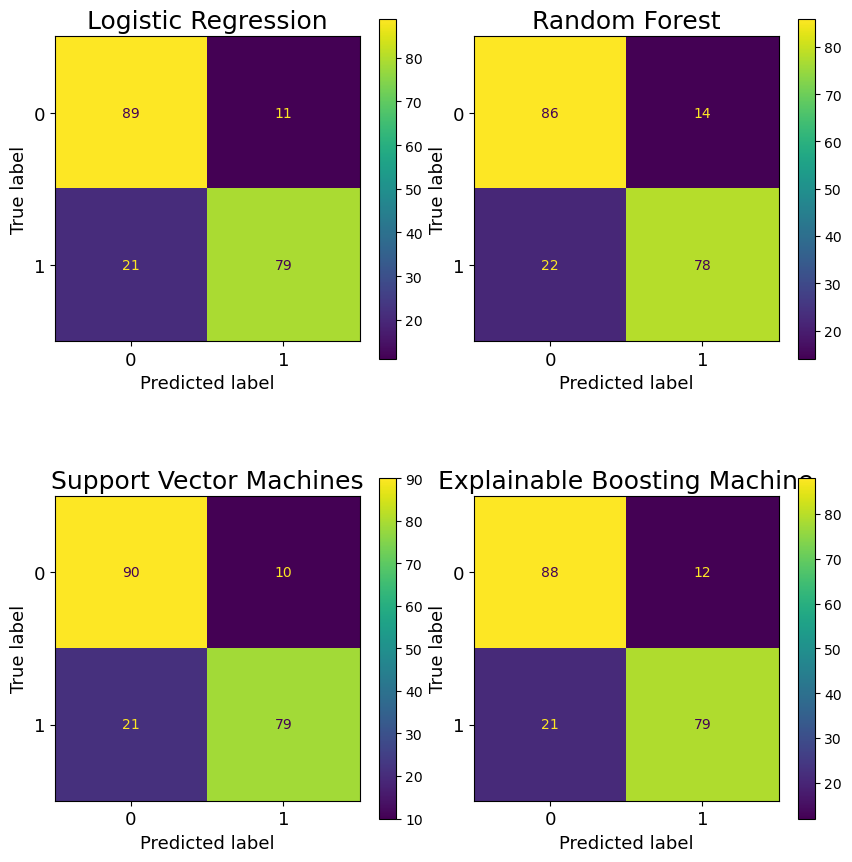

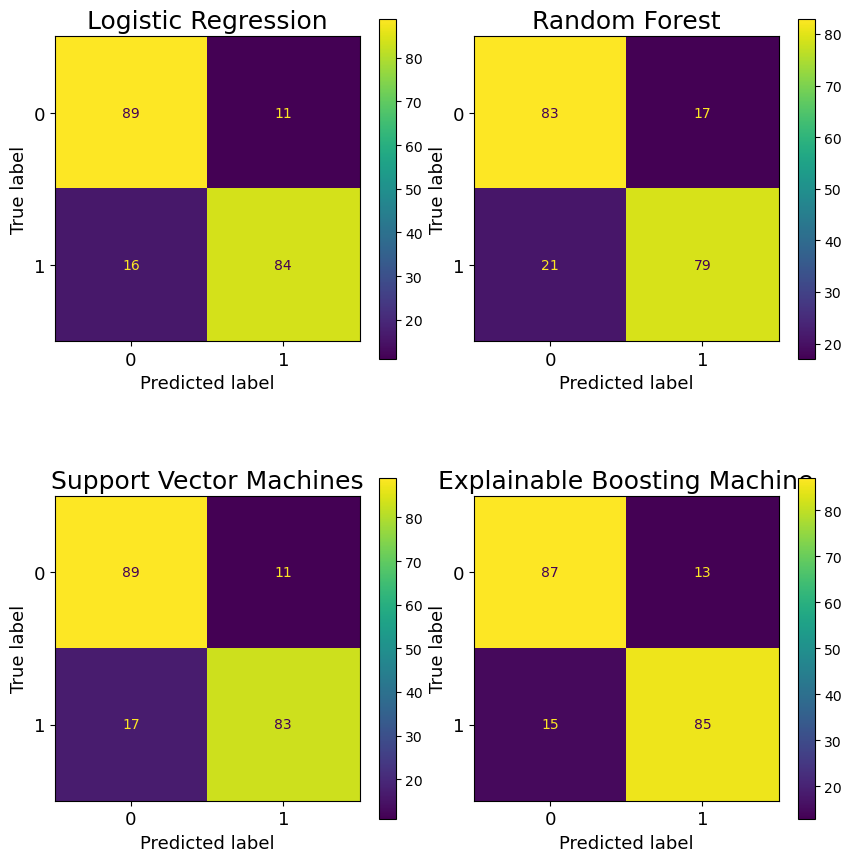

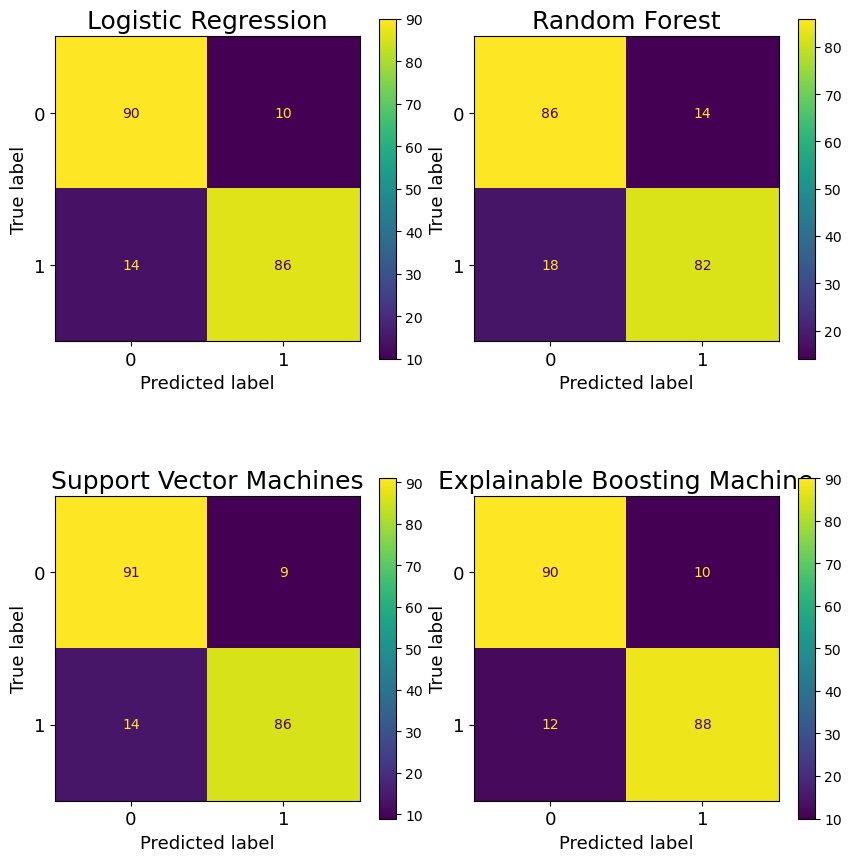

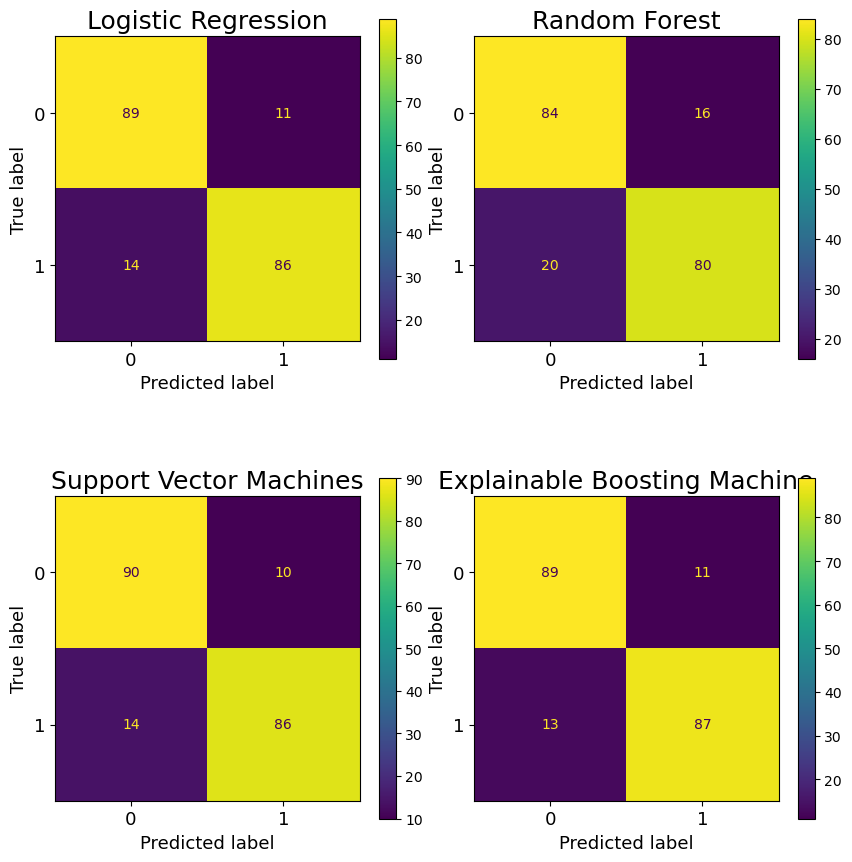

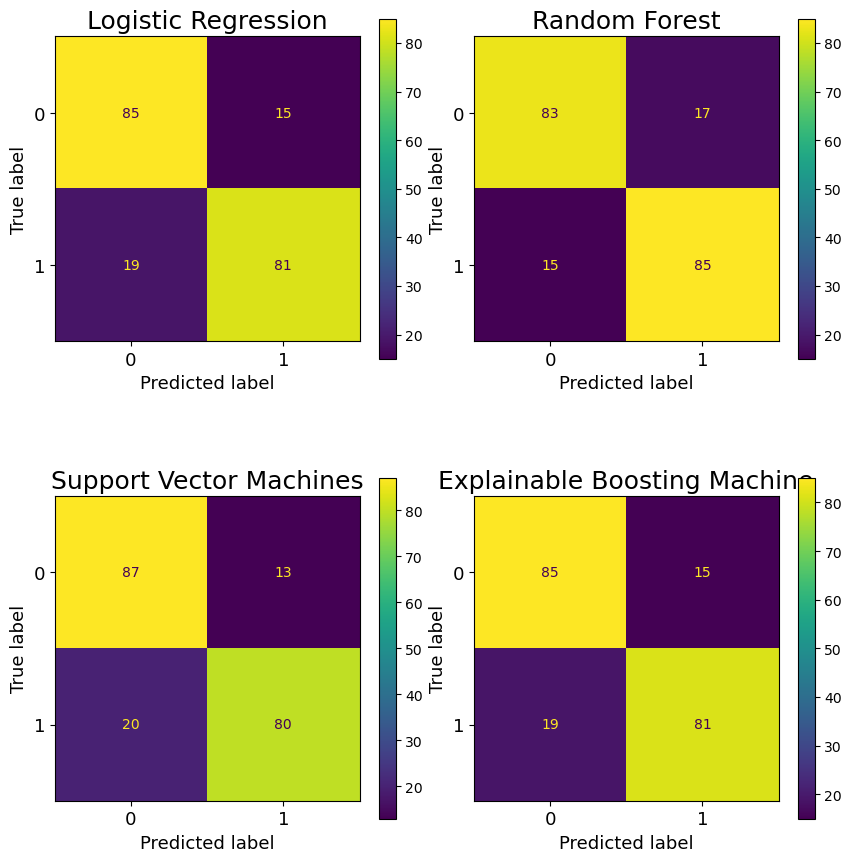

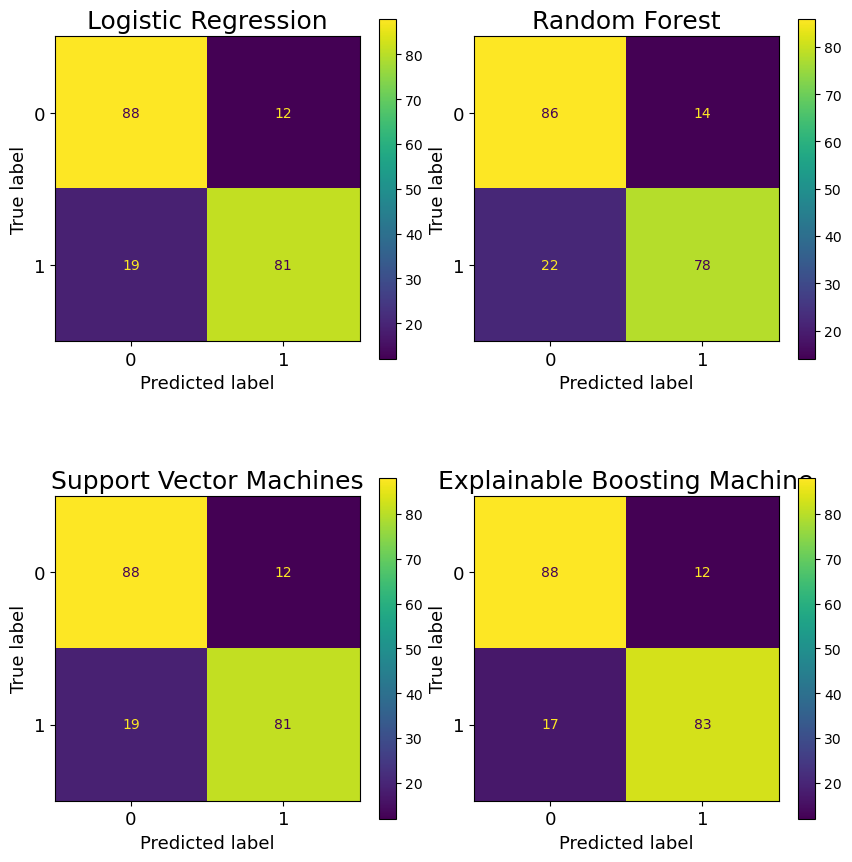

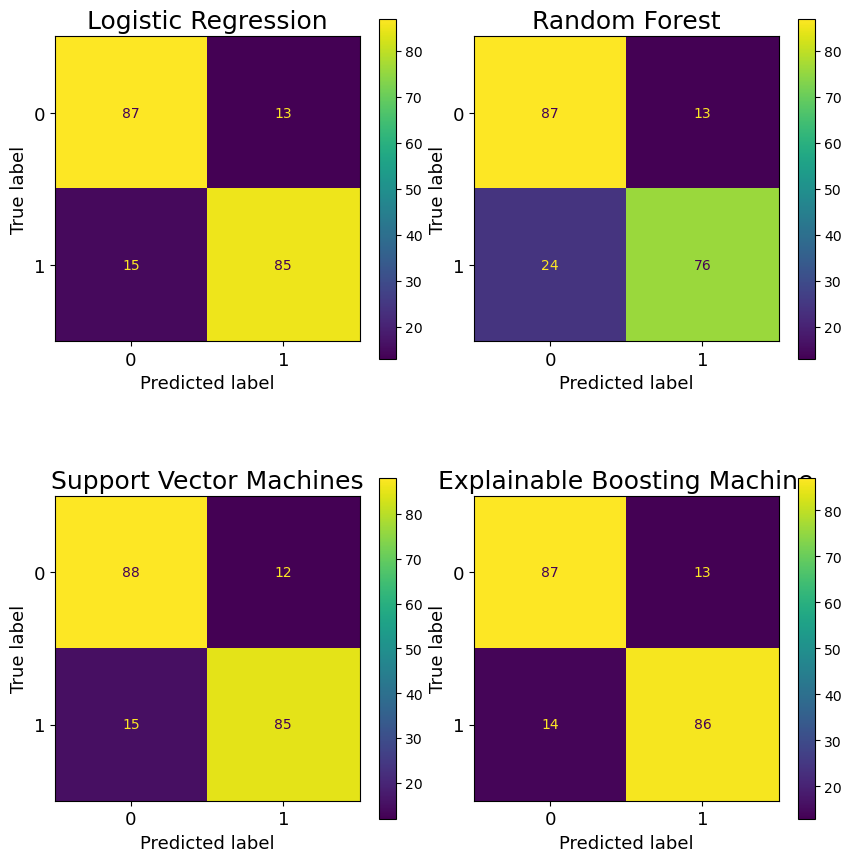

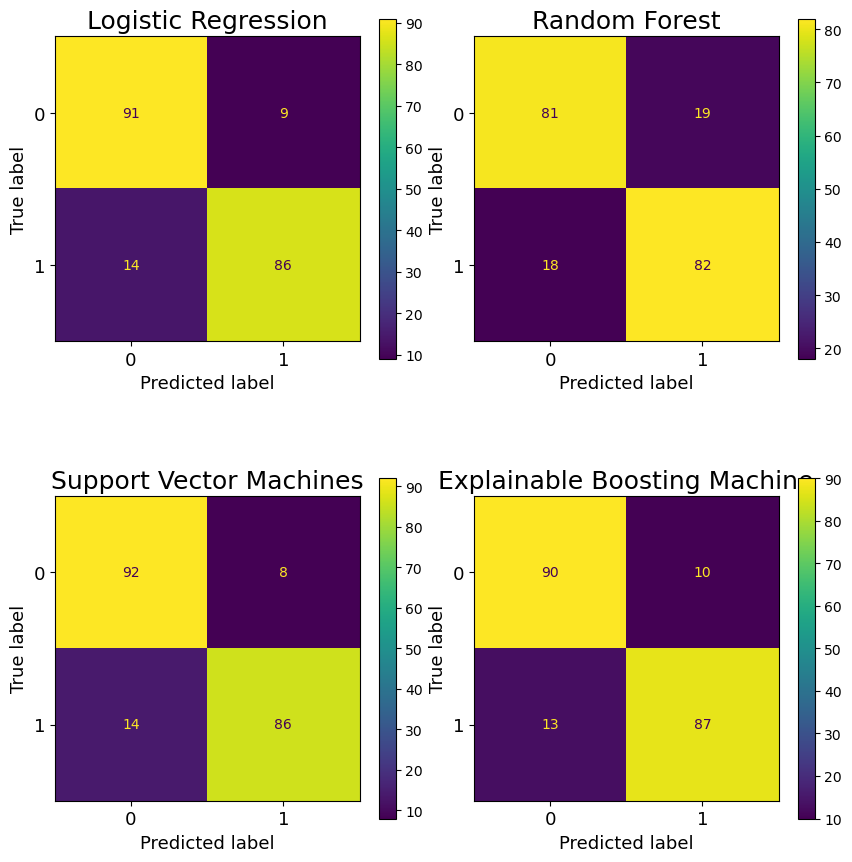

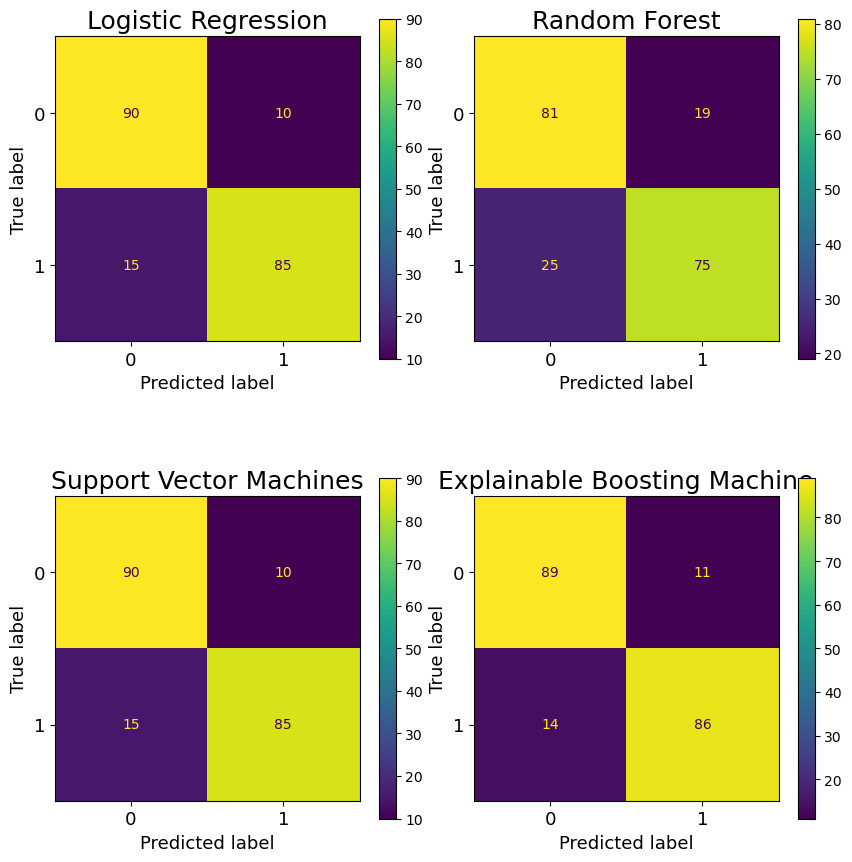

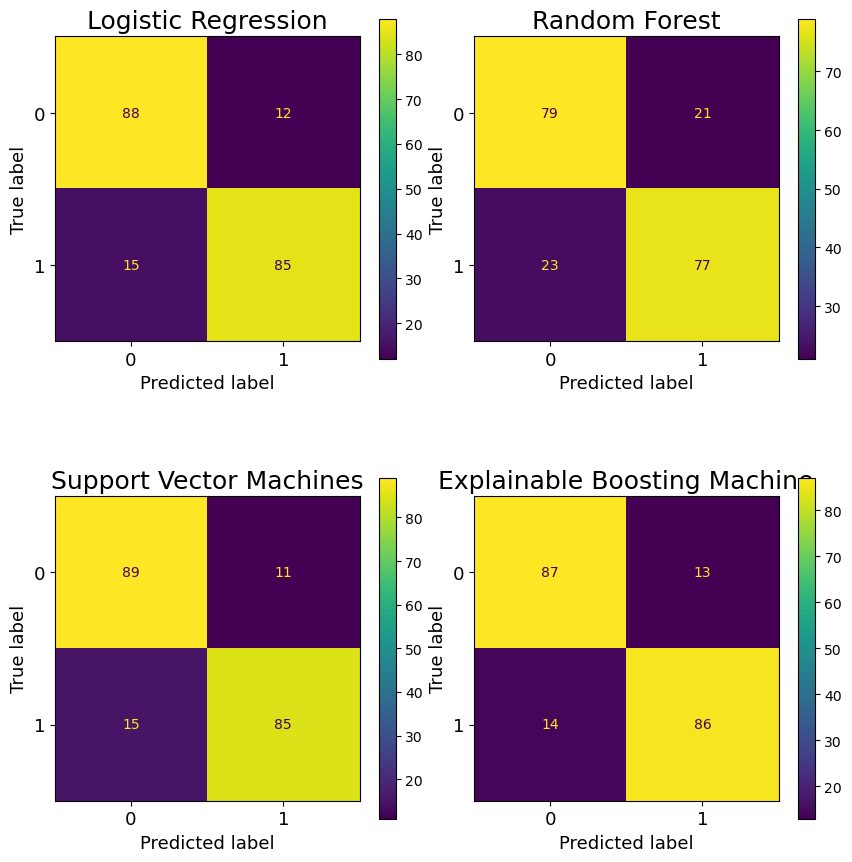

In [873]:
for i in range(sss_nsplits):
    lr_ye = lr_clfs[i].predict(X_tests_pd[i].to_numpy())
    rf_ye = rf_clfs[i].predict(X_tests_pd[i].to_numpy())
    svm_ye = svm_clfs[i].predict(X_tests_pd[i].to_numpy())
    ebm_ye = ebm_clfs[i].predict(X_tests_pd[i].to_numpy())
    visual.confusion_matrices_pred([Y_tests[i], Y_tests[i], Y_tests[i], Y_tests[i]], 
                              [lr_ye, rf_ye, svm_ye, ebm_ye],
                              nrows=2, 
                              ncols=2, 
                              figsize=(8, 8),
                              title_size=title_size,
                              label_size=label_size,
                              titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"]
                              )
    
    plt.savefig(f"{logs_dir}/synth_conf_matrices_{i}.png", bbox_inches="tight")
    
    plt.show()

## Curves

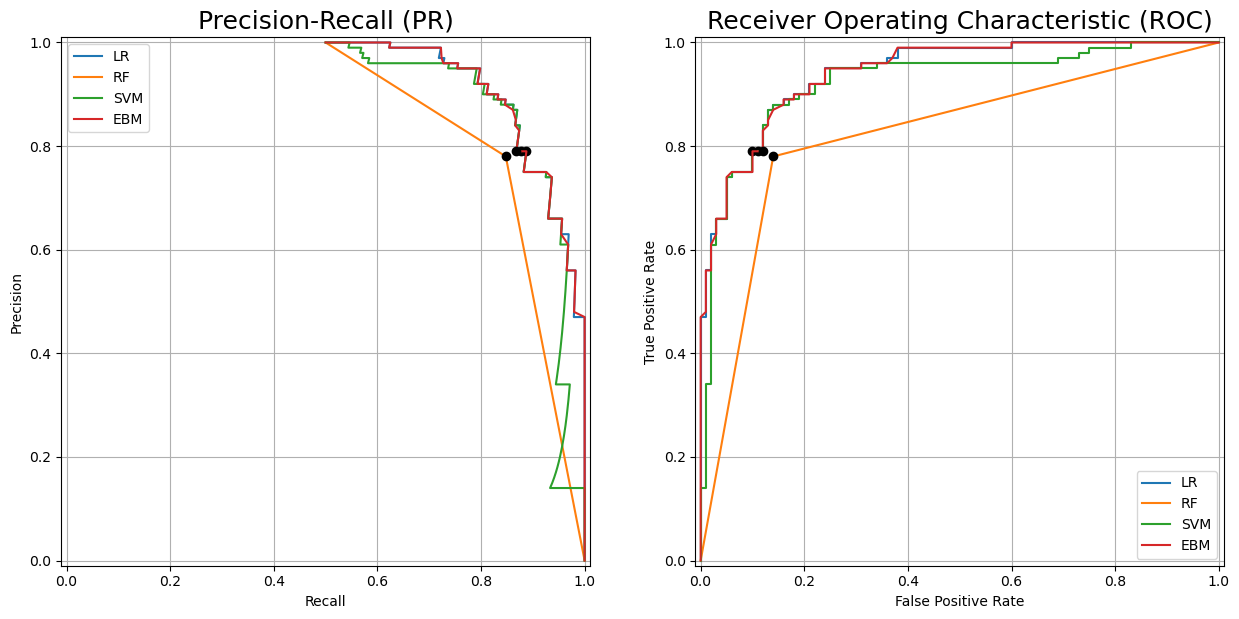

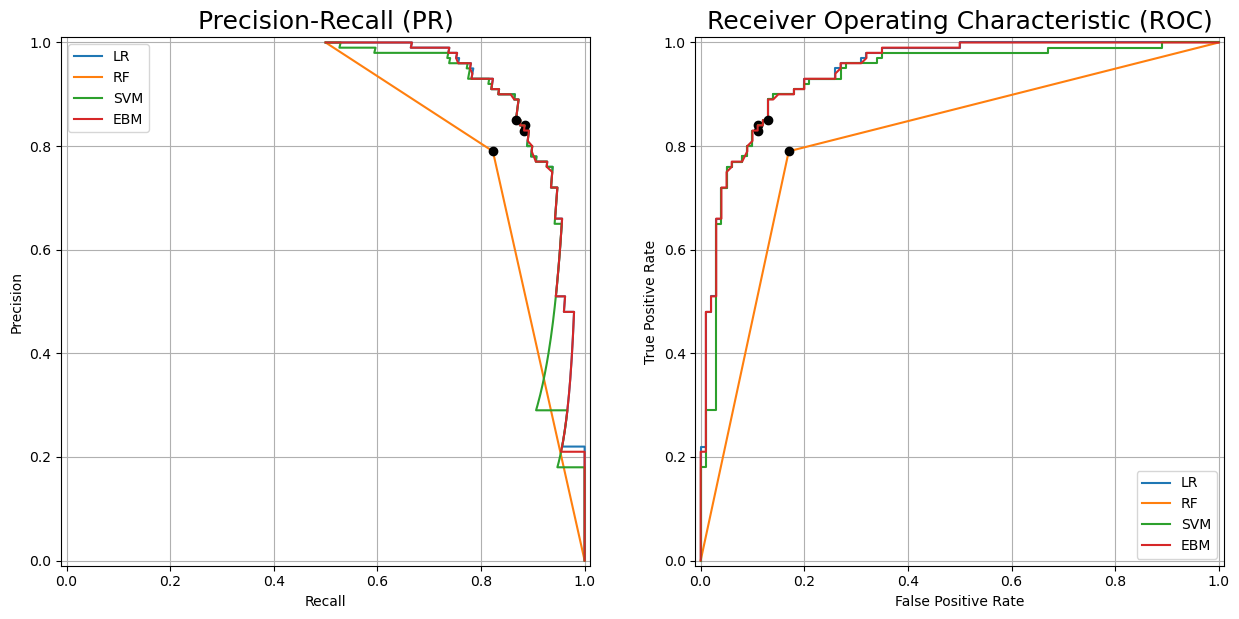

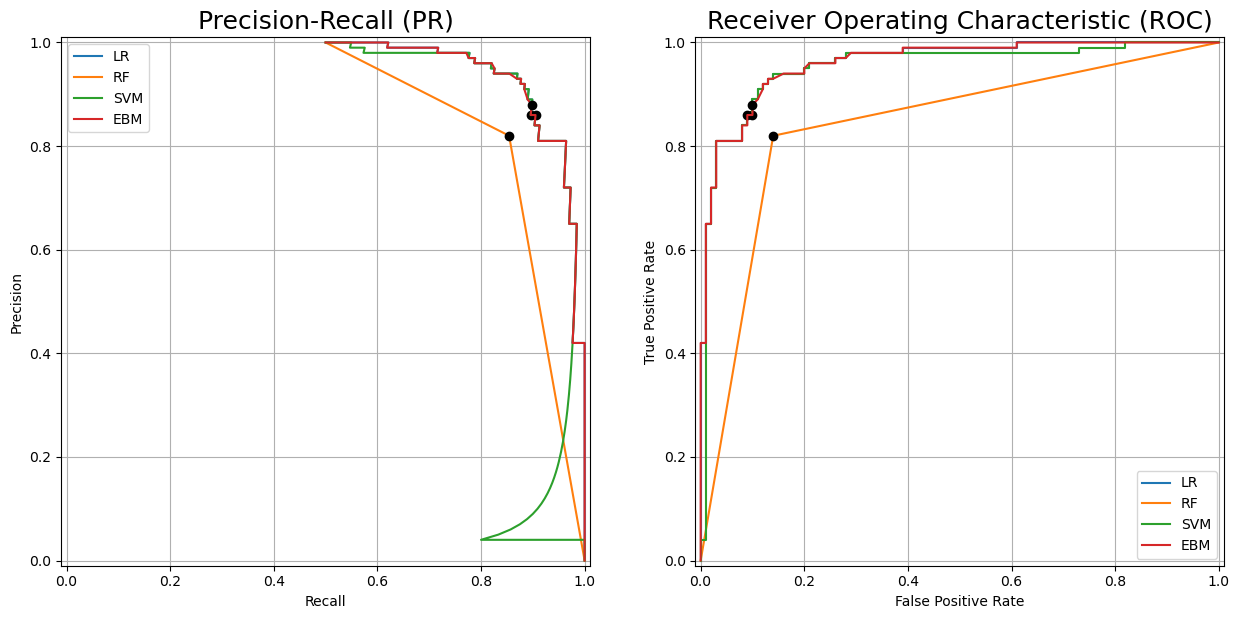

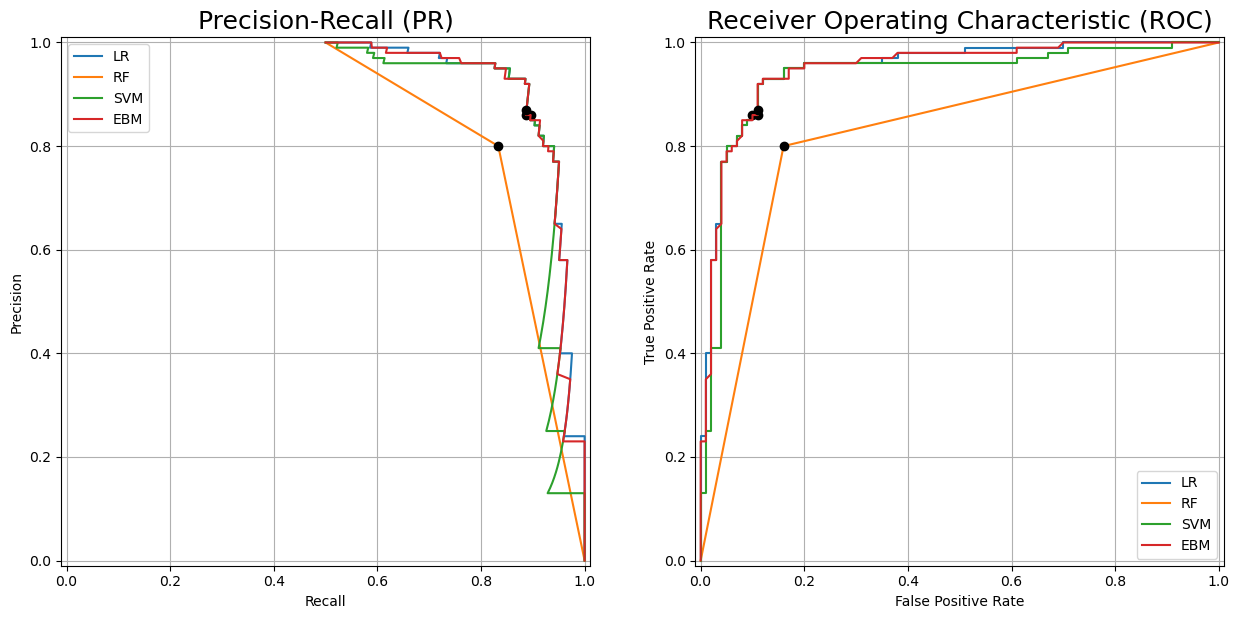

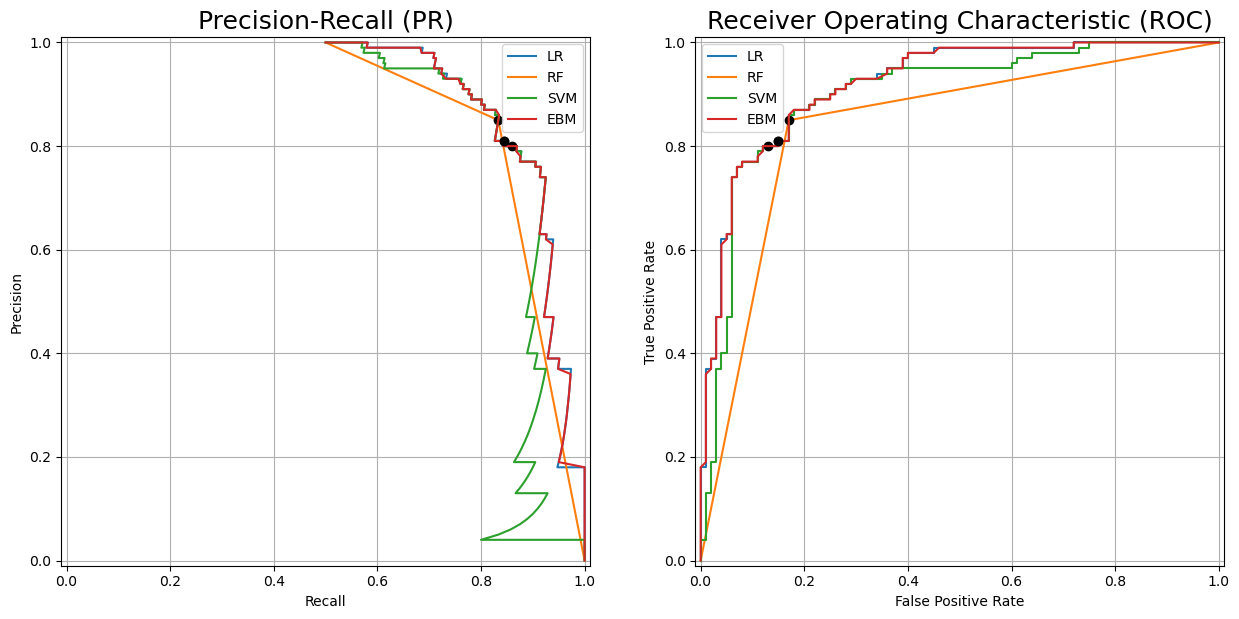

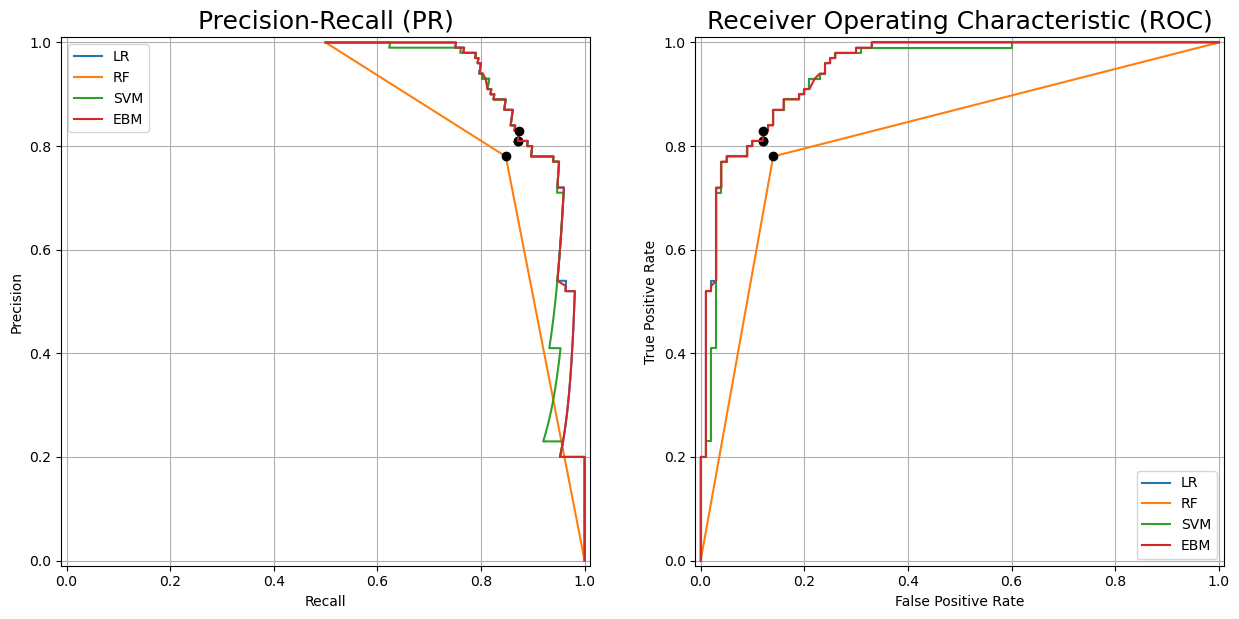

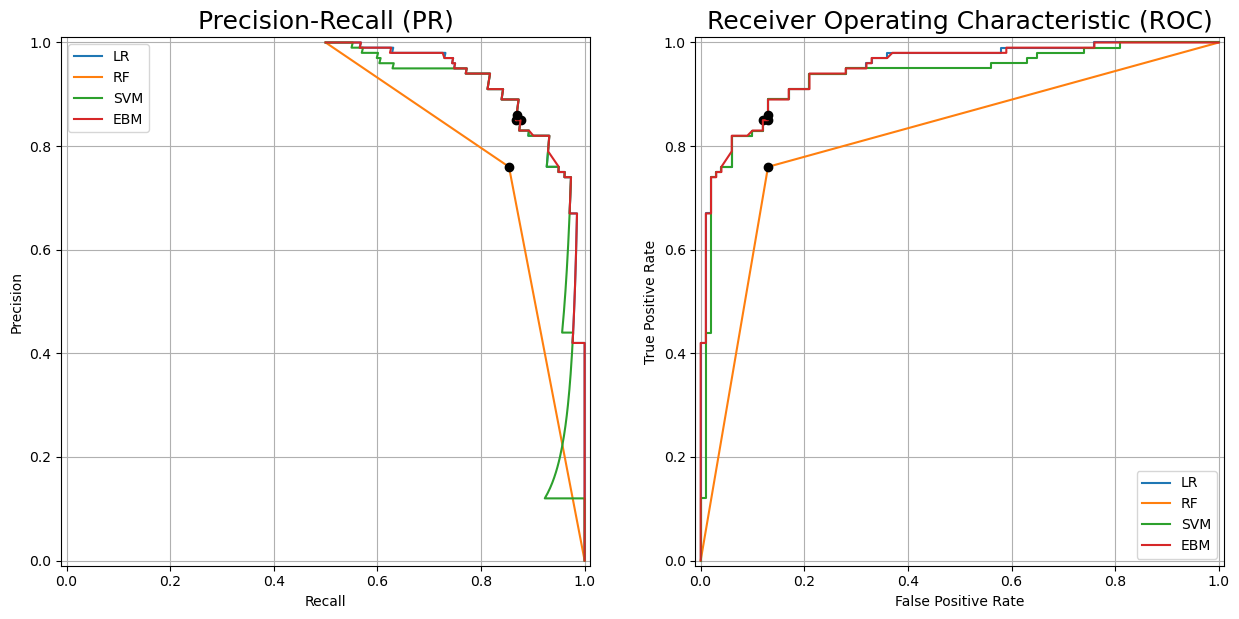

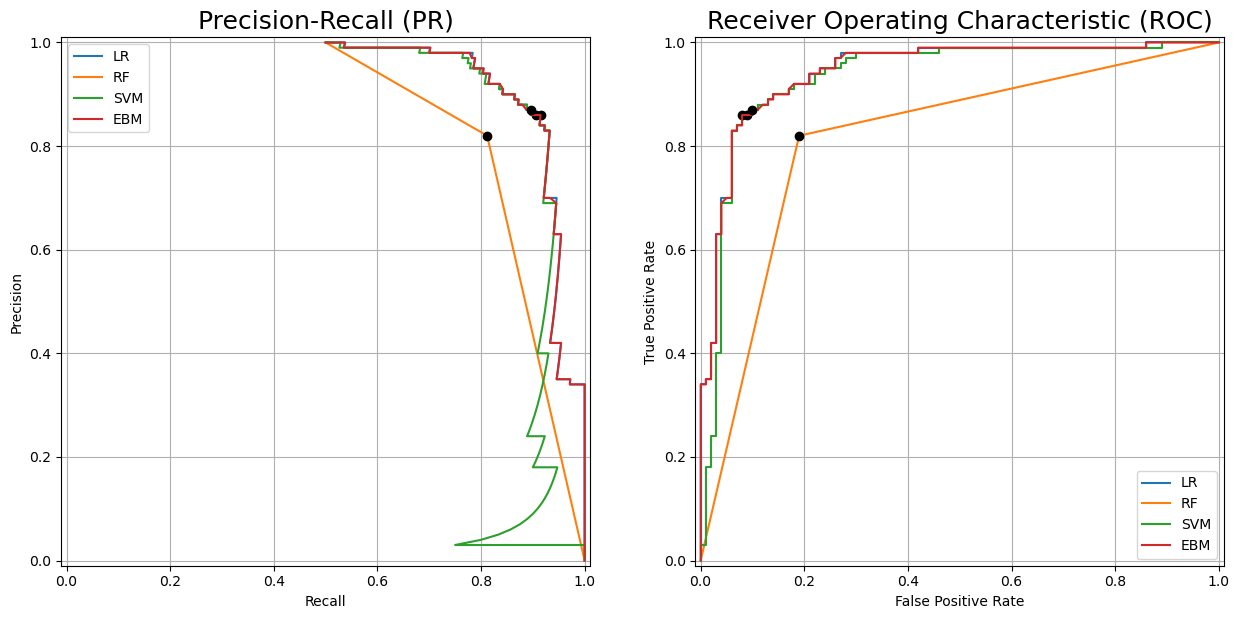

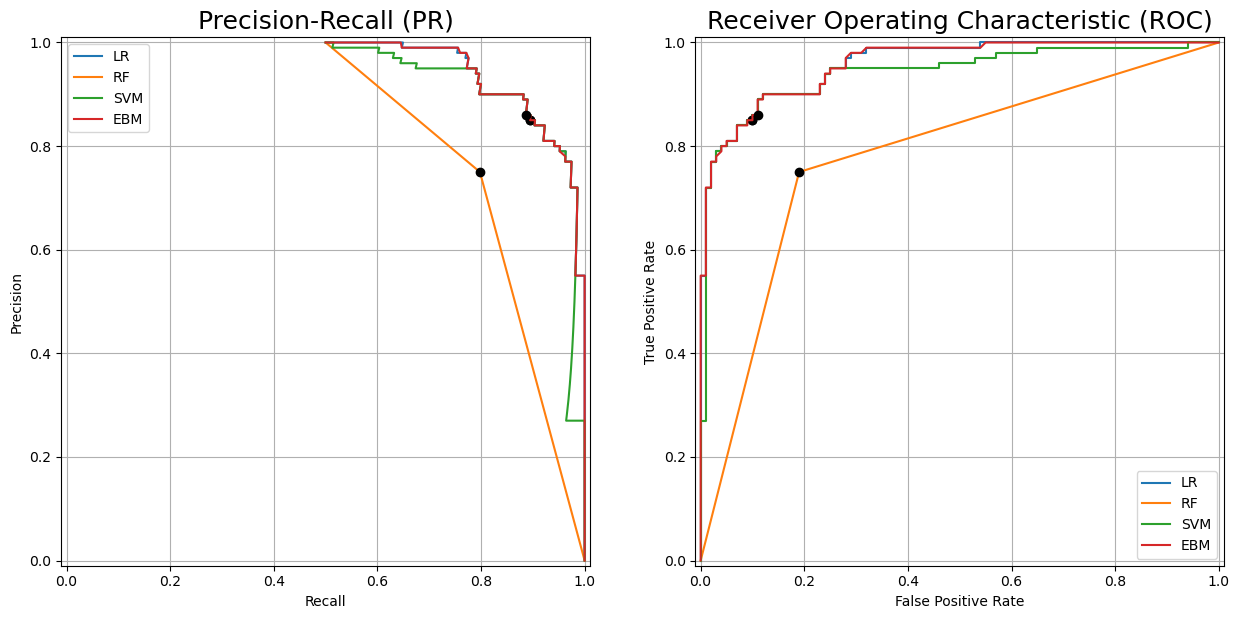

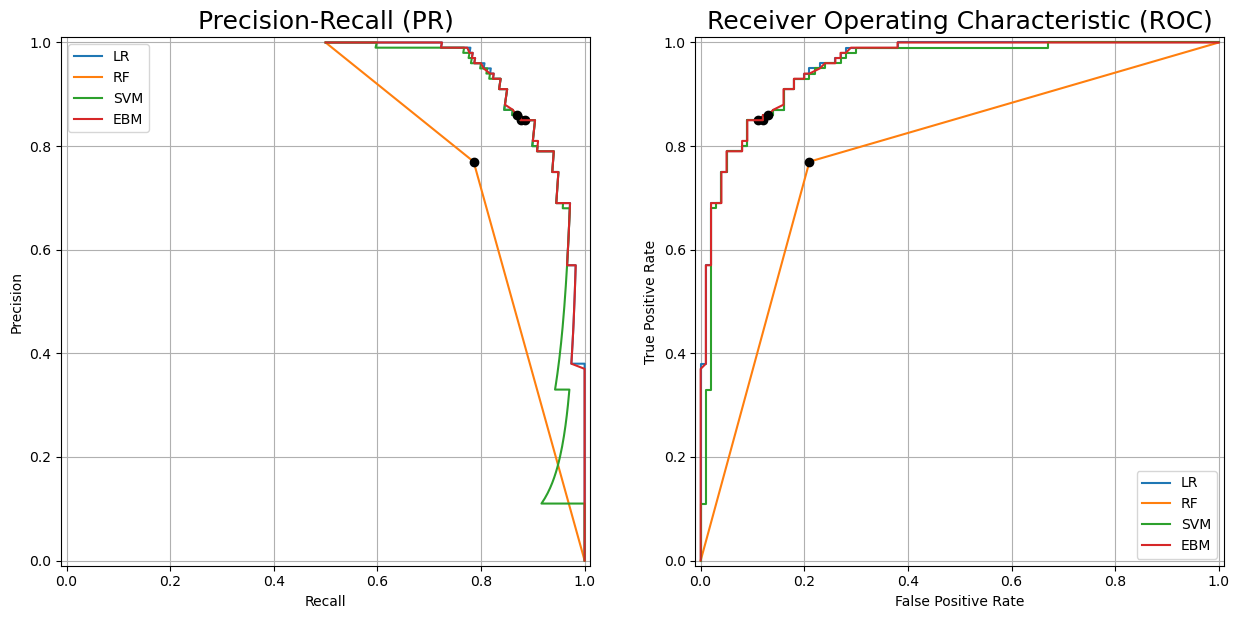

In [874]:
for i in range(sss_nsplits):
    plt.figure(figsize=(15, 10))
    
    lr_ye = lr_clfs[i].predict(X_tests_pd[i].to_numpy())
    rf_ye = rf_clfs[i].predict(X_tests_pd[i].to_numpy())
    svm_ye = svm_clfs[i].predict(X_tests_pd[i].to_numpy())
    ebm_ye = ebm_clfs[i].predict(X_tests_pd[i].to_numpy())
    
    lr_cm = lr_cms[i]
    rf_cm = rf_cms[i]
    svm_cm = svm_cms[i]
    ebm_cm = ebm_cms[i]
    
    lr_y2d = lr_clfs[i].predict_proba(X_tests_pd[i].to_numpy())[:, 1]
    rf_y2d = rf_clfs[i].predict_proba(X_tests_pd[i].to_numpy())[:, 1]
    svm_y2d = svm_clfs[i].decision_function(X_tests_pd[i].to_numpy())
    ebm_y2d = ebm_clfs[i].decision_function(X_tests_pd[i].to_numpy())
    
    plt.subplot(1,2,1)
    perf_analysis.compare_PR([Y_tests[i], Y_tests[i], Y_tests[i], Y_tests[i]], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])
    
    plt.subplot(1,2,2)
    perf_analysis.compare_ROC([Y_tests[i], Y_tests[i], Y_tests[i], Y_tests[i]], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])
    
    plt.savefig(f"{logs_dir}/synth_test_PR_ROC_{i}.png", bbox_inches="tight")
    
    plt.show()

## Local Explanations

### LIME

In [875]:
# for i in range(sss_nsplits):
#     lr_LIME_explanation = lr_limes[i].explain_instance(X_tests_pd[i].to_numpy()[Exp_index], lr_clfs[i].predict_proba)
#     lr_LIME_explanation.show_in_notebook(show_table=True)
#     lr_LIME_explanation.save_to_file(f"{logs_dir}/synth_LR_LIME_{i}.html")

In [876]:
# for i in range(sss_nsplits):
#     rf_LIME_explanation = rf_limes[i].explain_instance(X_tests_pd[i].to_numpy()[Exp_index], rf_clfs[i].predict_proba)
#     rf_LIME_explanation.show_in_notebook(show_table=True)
#     rf_LIME_explanation.save_to_file(f"{logs_dir}/synth_RF_LIME_{i}.html")

In [877]:
# for i in range(sss_nsplits):
#     svm_LIME_explanation = svm_limes[i].explain_instance(X_tests_pd[i].to_numpy()[Exp_index], svm_clfs[i].predict_proba)
#     svm_LIME_explanation.show_in_notebook(show_table=True)
#     svm_LIME_explanation.save_to_file(f"{logs_dir}/synth_SVM_LIME_{i}.html")

### SHAP & EBM

In [878]:
# for i in range(sss_nsplits):
#     Exp_inst_pd = X_tests_pd[i].iloc[Exp_index]
    
#     lr_shap_loc_values = np.array(lr_shaps[i].shap_values(Exp_inst_pd))
#     rf_shap_loc_values = np.array(rf_shaps[i].shap_values(Exp_inst_pd))
#     svm_shap_loc_values = np.array(svm_shaps[i].shap_values(Exp_inst_pd))
    
#     explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_shaps[i].expected_value[1], data=Exp_inst_pd),
#                 shap.Explanation(rf_shap_loc_values[1, :], rf_shaps[i].expected_value[1], data=Exp_inst_pd),
#                 shap.Explanation(svm_shap_loc_values[1, :], svm_shaps[i].expected_value[1], data=Exp_inst_pd)]
    
#     ebm_local = ebm_clfs[i].explain_local(X_tests_pd[i], Y_tests[i])
    
#     visual.local_shap(explanations, 
#                       ebm_local.data(key=Exp_index),
#                       nrows = 2,
#                       ncols = 2,
#                       figsize = (15,10),
#                       title_size = 22,
#                       label_size = label_size,
#                       titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
#                       ebm_colors = shap_colors / 255,
#                       num_features=9)
    
#     plt.savefig(f"{logs_dir}/synth_test_local_SHAP_EBM_{i}.png", bbox_inches="tight")
    
#     plt.show()


## Global Explanations

In [879]:
# for i in range(sss_nsplits):
#     lr_shap_global_values = lr_shaps[i].shap_values(X_tests_pd[i])
#     rf_shap_global_values = rf_shaps[i].shap_values(X_tests_pd[i])
#     svm_shap_global_values = svm_shaps[i].shap_values(X_tests_pd[i])

#     global_shap_values = [lr_shap_global_values,
#                       rf_shap_global_values,
#                       svm_shap_global_values]

#     ebm_global = ebm_clfs[i].explain_global()

#     visual.global_shap(global_shap_values,
#                        X_tests_pd[i],
#                        ebm_global.data(),
#                        nrows = 2,
#                        ncols = 2,
#                        figsize = (15, 10),
#                        title_size = 30,
#                        label_size = 15,
#                        titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
#                        ebm_colors = shap_colors/255,
#                        num_features=20)

#     plt.savefig(f"{logs_dir}/synth_test_global_SHAP_EBM{i}.png", bbox_inches="tight")

#     plt.show()